In [2]:
import re
import warnings
import pandas as pd
import numpy as np
from Bio import PDB
import torch

# from Bio.PDB import PDBList
import Bio.PDB.PDBParser as PDBParser
import Bio.PDB.PDBList as PDBList
import networkx as nx
# import torch_geometric
# import torch_geometric.utils
import pickle 
import os

In [3]:
from struc_feat import create_protein_graph

look at ego label subgraphs, with 70% or more overlap (from ProteinRPN)

In [77]:
pdb_path = "/Users/robsonlab/Teetly/AFEnzymeRelax/test/relax/A0A009IHW8_relaxed_0001.pdb"
#add in a csv active and binding site list processor later on, or name these pdb files accordingly
#ASSUME THAT THESE SITE LABELS ARE FROM THE COUNT OF 1 (NOT FROM 0)
functional_nodes = [4, 5, 6, 8, 9, 10,11, 15, 164, 168, 170]
graph  = create_protein_graph(pdb_path, functional_nodes)
# from model import triplets
# print(triplets(graph.edges, len(graph.nodes)))

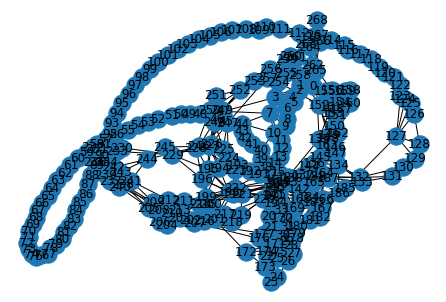

In [29]:
nx.draw(graph, with_labels=True)
#a look only a mother can love

In [78]:
#NEEDS TESTING
"""Adds functionality labels for the ego graph anchor centered at each functional node IF 

    >70% of a functional site (what is within 10 angsstroms of that node) is within the ego graph

    Args:
        protein_graph (nx.Graph): takes in protein graph processed by create_protein_graph()
        radius = 2 (int): radius of ego graph
        overlap_ratio_cutoff = 0.9 (float): ratio of functional nodes within 10 angstroms of a functional node that must be in ego graph for ego label to be 1

    Returns:
        label_graphs (dict): for each (ground truth = 1) functional node, what are the ground truth graph pdbsites
        graph is directly edited in-place to include ego_label attribute
    """
def ego_label_set(graph: nx.Graph, sites: list, radius = 2, overlap_ratio_cutoff = 0.9):
    ego_label = {node: 0 for node, att in graph.nodes(data=True)}
    label_graphs = (
        {}
    )  # for each (ground truth = 1) functional node what are the ground truth graph pdbsites
    functional_nodes = [
        node for node, att in graph.nodes(data=True) if att["y"] == 1
    ]
    for functional_node in functional_nodes:
        ego_subgraph = nx.ego_graph(graph, functional_node, radius=radius)
        #count number of functional nodes in ego subgraph
        func_subgraph_nodes = len([
            node for node, att in ego_subgraph.nodes(data=True) if att["y"] == 1
        ])
        #now find number of functional nodes within 10 angstroms of functional node
        #extract site nodes numbers, and compute distances
        total_func_nodes_ten_apart = len([
            node for node in sites if nx.shortest_path_length(graph, source=functional_node, target=node, weight='distance') <= 10
        ])
        #if this functional node has at least [overlap_ratio_cutoff] of the functional nodes within 10 angstroms of it, give it an ego label of 1 and add it
        #to label_graphs dictionary
        if func_subgraph_nodes / total_func_nodes_ten_apart > overlap_ratio_cutoff:
            ego_label[functional_node] = 1
            label_graphs[functional_node] = ego_subgraph
    nx.set_node_attributes(graph, ego_label, "ego_label")
    return label_graphs

In [79]:
print(ego_label_set(graph, functional_nodes))

{8: <networkx.classes.graph.Graph object at 0x15550a302bd0>, 9: <networkx.classes.graph.Graph object at 0x15550b1b73d0>, 10: <networkx.classes.graph.Graph object at 0x155509d28790>, 11: <networkx.classes.graph.Graph object at 0x155511396810>, 168: <networkx.classes.graph.Graph object at 0x155511396390>}
